In [1]:

import sys
print(sys.version)


3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:41:22) [MSC v.1929 64 bit (AMD64)]


In [47]:
from pyspark.sql import SparkSession
import os

# Set required environment variables for Spark to work properly
os.environ["JAVA_HOME"] = r"C:\Program Files\Eclipse Adoptium\jdk-8.0.452.9-hotspot"
os.environ["PYSPARK_PYTHON"] = r"C:\Users\Mustafa\anaconda3\envs\pyspark_env\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\Mustafa\anaconda3\envs\pyspark_env\python.exe"

# Define your desired path
windows_path = r"C:\Users\Mustafa\Documents\Uni_Stuff\Big Data\logs"

# Ensure the directory exists
os.makedirs(windows_path, exist_ok=True)

# Convert to URI format for Spark
event_log_path = "file:///" + windows_path.replace("\\", "/").replace(" ", "%20")

# Create SparkSession using only 1 thread (avoids socket errors)
spark = SparkSession.builder \
    .appName("ClassImbalance_1") \
    .master("local[8]") \
    .config("spark.executorEnv.PYSPARK_PYTHON", os.environ["PYSPARK_PYTHON"]) \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", event_log_path) \
    .getOrCreate()

context = spark.sparkContext

In [3]:
default_parallelism = spark.sparkContext.defaultParallelism
print(f"Default Parallelism: {spark.sparkContext.defaultParallelism}")

Default Parallelism: 8


### Import all the necessary libraries here

In [52]:
import matplotlib.pyplot as plt
import math
from pyspark.sql.functions import when, col, sum, count
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRandomForestClassifier
import time
from sklearn.ensemble import RandomForestClassifier as skLearnRandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score as sk_f1_score
from scipy.stats import mode
import numpy as np
import random
from pyspark.ml.linalg import DenseVector
from pyspark.sql import Row
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Load the credit card dataset and print the schema to identify the column datatypes

In [5]:
creditCard_df = spark.read.csv('creditcard.csv', header=True, inferSchema=True)
creditCard_df.show(5, truncate=False)
creditCard_df.printSchema()
creditCard_df.cache()

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|V1                |V2                 |V3              |V4                |V5                 |V6                 |V7                 |V8                |V9                |V10                |V11               |V12               |V13               |V14               |V15               |V16               |V17               |V18                |V19               |V20                |V21                 |V22                |V23  

DataFrame[Time: double, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double, Class: int]

The schema above shows columns V1 to V28 which are obtained as a result of Principal component analysis as mentioned in the dataset source.

#### Identify if the dataset contains any null values

In [6]:
null_counts = creditCard_df.select([sum(when(col(a).isNull(), 1)\
                           .otherwise(0))\
                           .alias(a) for a in creditCard_df.columns])
null_counts.show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Identify the total number of records in the dataset.

In [7]:
total_count = creditCard_df.count()

total_count

284807

The dataset contains a column class which indicates rather the row belongs to farud or non-fraud transaction.
A value of 1 indicates fraud transaction whereas value of 0 indicates non-fraud.
Identify the non-fraud to fraud data ratio in the original data set.

In [8]:
fraud_count = creditCard_df.filter(creditCard_df['class'] == 1).count()

non_fraud_count = creditCard_df.filter(creditCard_df['class'] == 0).count()

ratio = non_fraud_count / fraud_count

print(f"Fraud Count: {fraud_count}")
print(f"Non-Fraud Count: {non_fraud_count}")
print(f"Non-Fraud to Fraud Ratio: {math.floor(ratio)}:1")


Fraud Count: 492
Non-Fraud Count: 284315
Non-Fraud to Fraud Ratio: 577:1


Define the imbalance ratios which will be implemented and display the ratios as a pie chart.

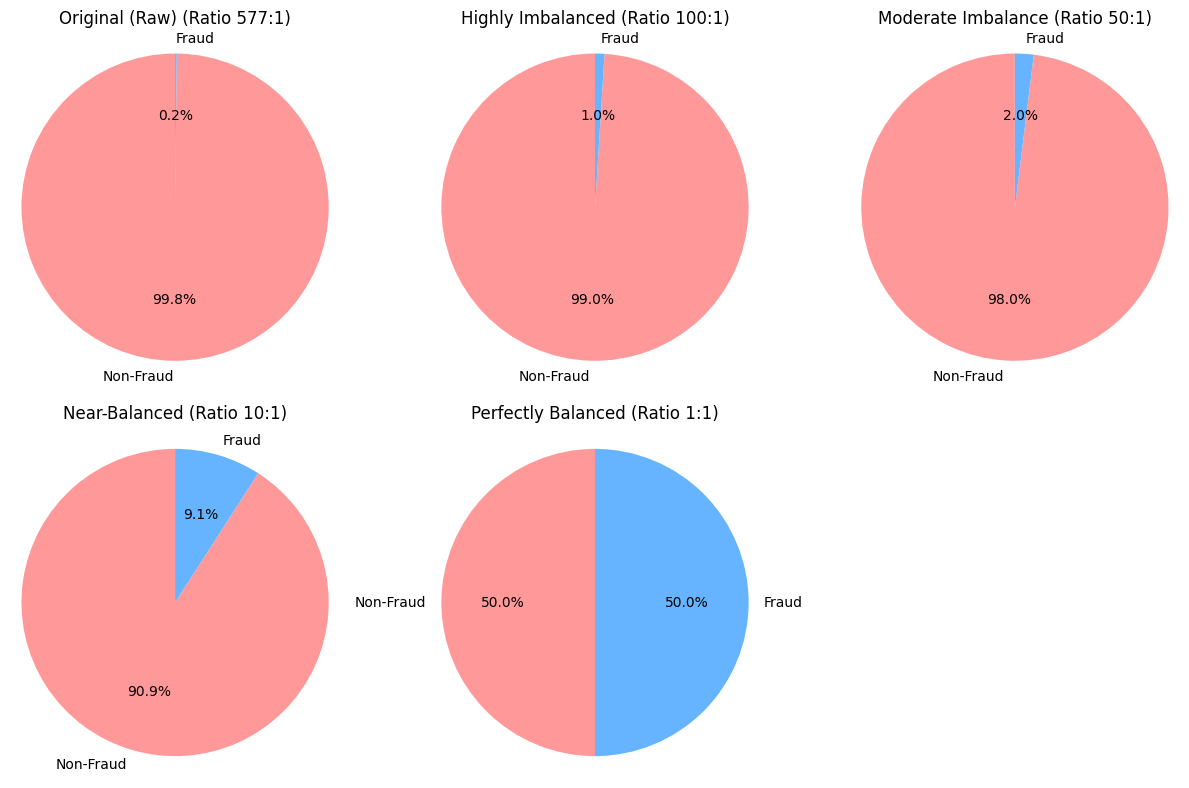

In [9]:

dataset_type = ['Original (Raw)', 'Highly Imbalanced', 'Moderate Imbalance', 'Near-Balanced', 'Perfectly Balanced']
ratios = [(577, 1), (100, 1), (50, 1), (10, 1), (1, 1)]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, (dataset_type, (non_fraud, fraud)) in enumerate(zip(dataset_type, ratios)):

    axes[i].pie([non_fraud, fraud], labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
    axes[i].axis('equal')
    axes[i].set_title(f'{dataset_type} (Ratio {non_fraud}:{fraud})')

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

#plt.savefig('class_imbalance_visualization.png', format='png')


The columns which will be considerd as features are identified below and converted to a vector

In [10]:
feature_cols = [a for a in creditCard_df.columns if a != "Class"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
new_df = assembler.transform(creditCard_df)


Class column is being considered as label here and datafram is named a final_df which will be used from here.

In [11]:
final_df = new_df.select("features", col("Class").alias("label"))

Identify the fraud and non-fraud count from the final dataframe

In [12]:
fraud_df = final_df.filter(col("label") == 1)
nonFraud_df = final_df.filter(col("label") == 0)

fraud_df.repartition(4)
nonFraud_df.repartition(4)

fraud_df.cache()
nonFraud_df.cache()

fraud_count = fraud_df.count()
nonFraud_count = nonFraud_df.count()

print(f"Fraud count: {fraud_count}, Non Fraud count: {nonFraud_count}")

Fraud count: 492, Non Fraud count: 284315


Define a new function random_undersampling which will take ratio as an input and return the new datafram with desired ratio by reducing the non-fraud count.

In [13]:
def random_undersampling(ratio):

    desired_nonFraud_count = ratio * fraud_count
    fraction = desired_nonFraud_count / nonFraud_count
    sampled_NonFraud_df = nonFraud_df.sample(withReplacement=False, fraction=fraction, seed=42)
    desired_ratio_df = sampled_NonFraud_df.union(fraud_df)

    return desired_ratio_df


Define a new function random_oversampling which will take ratio as an input and return the new dataframe with desired ratio by increasing the fraud data count.

In [14]:
def random_oversampling(ratio):
    desired_fraud_count = nonFraud_count / ratio
    multiplier = desired_fraud_count / fraud_count

    sampled_fraud_df = fraud_df.sample(withReplacement=True, fraction=multiplier, seed=42)

    desired_ratio_df = sampled_fraud_df.union(nonFraud_df)

    return desired_ratio_df

In the case of Synthetic Minority Oversampling Technique (SMOTE) new data from the minority class is generated sythetically to achieve the desired imbalance ratio. From here onwards implementation involves the sythetic data generation using k nearest neighbour technique.

Since the minority data belongs to the fraud class, all the features of fraud will be collected into the single fraud vector.

In [15]:
fraud_vectors = fraud_df.select("features").rdd.map(lambda r: r.features.toArray()).collect()

Numpy library is being used to calculate the euclidean distance between the two vectors.

In [16]:
def euclidean_distance(v1, v2):
    return np.linalg.norm(np.array(v1) - np.array(v2))

In order to check if two vectors are equal we need to compare the individual features of the two vector. Below function will check if two vectors are equal or not.

In [17]:
def check_equal_vectors(v1, v2):
    return all(a == b for a, b in zip(v1, v2))

Now define a function which will identify and return a list of nearest vectors. The function requires the parameters such as:

*   fraud_vectors: List of fraud vectors
*   orginal_vectors: A vector around which the neighbours are need to be identified.
* k: Number of neigbhours which will be returned.



In [18]:
def find_k_nearest_neighbors(fraud_vectors, original_vector, k=5):

    possible_candidates = [v for v in fraud_vectors if not check_equal_vectors(v, original_vector)]

    sorted_neighbors = sorted(possible_candidates, key=lambda v: euclidean_distance(original_vector, v))

    return sorted_neighbors[:k]


Implement a function which will generate a single sythetic sample. The sample will be generated by interpolating between randomly selected neighbour and the originaly selected vector using a factor alpha.

In [19]:
def generate_synthetic_sample(fraud_vectors, original_vector, k=5):

    generated_neighbors = find_k_nearest_neighbors(fraud_vectors=fraud_vectors, original_vector=original_vector, k=k)

    selected_neighbour = random.choice(generated_neighbors)

    alpha = random.random()
    synthetic = [original_vector[i] + alpha * (selected_neighbour[i] - original_vector[i]) for i in range(len(original_vector))]

    return Row(features=DenseVector(synthetic), label=1)

Define and implement a function which will require a target ratio as an input and than return the data frame with desired ratio between fraud and non fraud data.

In [20]:
def generate_smote(target_ratio, k=5):
    target_fraud_count = nonFraud_count /target_ratio
    synthetic_samples_required = int(max(target_fraud_count - fraud_count, 0))

    if synthetic_samples_required <= 0:
      return fraud_df

    selected_vector = random.choice(fraud_vectors)

    synthetic_samples = []
    for _ in range(synthetic_samples_required):
      synthetic_samples.append(generate_synthetic_sample(fraud_vectors, selected_vector, k=k))

    synthetic_df = spark.createDataFrame(synthetic_samples)

    desiredRatio_df = nonFraud_df.union(fraud_df).union(synthetic_df)

    return desiredRatio_df

# Global Approach
Implement a random forest model which uses a global distributed approach. The function covers the complete pipeline for random forest model which will return the accuracy, F1 score and area under the curve. The major aspects of the function is as follows:


*   Split the dataset into the train and test dataframes.
*   Define random forest classifier and build a pipeline.

The parameter such as Number of trees (numTrees) and Maximum depth of each tree has default values in PySpark which are 20 and 5 respectivey. However parameter grid and cross validation is being used here to identify the best model by varying these parameters.

In [21]:
def global_random_forest_model(df, ratio, technique, num_partitions, seed=42, test_size=0.2):

    job_prefix = f"{technique}_{ratio}_{num_partitions}_Global_RF"
    
    train_df, test_df = df.randomSplit([1 - test_size, test_size], seed=seed)
    random_forest = SparkRandomForestClassifier(featuresCol="features", labelCol="label", seed=seed)

    pipeline = Pipeline(stages=[random_forest])

    spark.sparkContext.setJobGroup(f"{job_prefix}", f"Global ({technique}, ratio {ratio}:1, partitions{num_partitions})")
    model = pipeline.fit(train_df)
    
    predictions = model.transform(test_df)
  
    classification_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    auc = classification_evaluator.evaluate(predictions)

    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = accuracy_evaluator.evaluate(predictions)

    f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = f1_evaluator.evaluate(predictions)

    spark.sparkContext.setJobGroup("", "")
    spark.catalog.clearCache()

    return auc, accuracy, f1_score


# Local Approach

Local approach uses a RandomForestClassifier from scikit learn and train a model per partition and majority voting is used.

In [22]:
def local_distributed_random_forest(df, ratio, technique, num_partitions, num_trees=20, max_depth=5, seed=42, test_size = 0.2):
    job_prefix = f"{technique}_{ratio}_{num_partitions}_Local_RF"
    def train_each_model_partition(iteration):
        rows = list(iteration)
        if not rows:
            return iter([])

        features = np.array([row.features.toArray() for row in rows])
        target = np.array([row.label for row in rows])

        model = skLearnRandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, random_state=seed)
        model.fit(features, target)
        return [model]

    train_df, test_df = df.randomSplit([1 - test_size, test_size], seed=seed)

    spark.sparkContext.setJobGroup(f"{job_prefix}", f"Local ({technique}, ratio {ratio}:1, partitions{num_partitions})")
    local_models = train_df.rdd.mapPartitions(train_each_model_partition).collect()

    test_df_features = np.array(test_df.select("features").rdd.map(lambda row: row.features.toArray()).collect())
    test_df_labels = np.array(test_df.select("label").rdd.map(lambda row: row.label).collect())
    spark.sparkContext.setJobGroup("", "")

    all_predictions = [model.predict(test_df_features) for model in local_models]
    majority_predictions = mode(np.array(all_predictions).T, axis=1).mode.flatten()

    accuracy = accuracy_score(test_df_labels, majority_predictions)
    auc = roc_auc_score(test_df_labels, majority_predictions)
    f1 = sk_f1_score(test_df_labels, majority_predictions)

    return accuracy, auc, f1


# Performance Evaluation UDF

In [23]:
def evaluate_model_performance(dfs, technique, approach, results, partition_list=[2, 4, 8, 16]):
    if results is None:
        results = []

    for i, (ratio, dataset) in enumerate(dfs.items(), start=1):
        for partitions in partition_list:
            print(f"\nEvaluating Ratio {ratio}:1 with {partitions} partitions...")

            dataset_part = dataset.repartition(partitions)
            start_time = time.time()

            if approach == "Global":
                auc, accuracy, f1_score = global_random_forest_model(dataset_part, ratio, technique, partitions)
            elif approach == "Local":
                auc, accuracy, f1_score = local_distributed_random_forest(dataset_part, ratio, technique, partitions)
            else:
                print("Unknown approach. Skipping.")
                continue

            end_time = time.time()
            duration = end_time - start_time

            results.append({
                "technique": technique,
                "approach": approach,
                "ratio": ratio,
                "partitions": partitions,
                "accuracy": accuracy,
                "auc": auc,
                "f1": f1_score,
                "time": duration
            })

            print(f"→ Accuracy: {accuracy:.4f}")
            print(f"→ AUC: {auc:.4f}")
            print(f"→ F1 Score: {f1_score:.4f}")
            print(f"→ Execution Time: {duration:.4f} seconds")
            print("-" * 60)

    return results


Now that we have defined the function for undersampling, oversampling and smote we will use those function generate the datasets with the required ratio. After the generation of datasets local and global random forest models will be used to evaluate the models on the predefined matrices such as accuracy, auc etc.

In [24]:
all_results = []
ratios = [1, 10, 50, 100, 577]

# Random Undersampling

The code below will generate the datasets with the required ratio using undersampling technique.

In [25]:
undersampled_dfs = {}

for r in ratios:
    undersampled_dfs[r] = random_undersampling(ratio=r)

Print the count of non-fraud and fraud for each ratio to confirm if the datasets are generated correctly.

---



In [26]:
for ratio, df in undersampled_dfs.items():
    fraud_count_undersampled = df.filter(col("label") == 1).count()
    nonfraud_count_undersampled = df.filter(col("label") == 0).count()

    print(f"Ratio {ratio}:1 → Non-Fraud = {nonfraud_count_undersampled}, Fraud = {fraud_count_undersampled}")

Ratio 1:1 → Non-Fraud = 459, Fraud = 492
Ratio 10:1 → Non-Fraud = 4972, Fraud = 492
Ratio 50:1 → Non-Fraud = 24616, Fraud = 492
Ratio 100:1 → Non-Fraud = 49272, Fraud = 492
Ratio 577:1 → Non-Fraud = 283907, Fraud = 492


The dataframes with desired ratio and partitions have been obtained. Now we move towards the random forest models with undersampled datasets.

**Global distributed approach using undersampled data.**

In [27]:
all_results = evaluate_model_performance(undersampled_dfs, "Undersampling", "Global", all_results)


Evaluating Ratio 1:1 with 2 partitions...
→ Accuracy: 0.9415
→ AUC: 0.9828
→ F1 Score: 0.9412
→ Execution Time: 4.2945 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 4 partitions...
→ Accuracy: 0.9425
→ AUC: 0.9858
→ F1 Score: 0.9422
→ Execution Time: 13.8027 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 8 partitions...
→ Accuracy: 0.9319
→ AUC: 0.9610
→ F1 Score: 0.9317
→ Execution Time: 12.9531 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 16 partitions...
→ Accuracy: 0.9130
→ AUC: 0.9720
→ F1 Score: 0.9132
→ Execution Time: 13.7082 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 2 partitions...
→ Accuracy: 0.9826
→ AUC: 0.9465
→ F1 Score: 0.9817
→ Execution Time: 13.3937 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 4 partitions...
→ Acc

**Local distributed approach using undersampled data.**

In [28]:
all_results = evaluate_model_performance(undersampled_dfs, "Undersampling", "Local", all_results)


Evaluating Ratio 1:1 with 2 partitions...
→ Accuracy: 0.9258
→ AUC: 0.9298
→ F1 Score: 0.9200
→ Execution Time: 11.2837 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 4 partitions...
→ Accuracy: 0.9337
→ AUC: 0.9368
→ F1 Score: 0.9290
→ Execution Time: 16.0690 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 8 partitions...
→ Accuracy: 0.9260
→ AUC: 0.9267
→ F1 Score: 0.9222
→ Execution Time: 25.3151 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 16 partitions...
→ Accuracy: 0.9181
→ AUC: 0.9130
→ F1 Score: 0.9149
→ Execution Time: 43.0694 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 2 partitions...
→ Accuracy: 0.8944
→ AUC: 0.9816
→ F1 Score: 0.8820
→ Execution Time: 12.1622 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 4 partitions...
→ Ac

# Random Oversampling

The code below will generate the datasets with the required ratio using oversampling technique.

In [29]:
oversampled_dfs = {}

for r in ratios:
    oversampled_dfs[r] = random_oversampling(ratio=r)

Print the count of non-fraud and fraud for each ratio to confirm if the datasets are generated correctly.

In [30]:
for ratio, df in oversampled_dfs.items():
    fraud_count_oversampled = df.filter(col("label") == 1).count()
    nonfraud_count_oversampled = df.filter(col("label") == 0).count()

    print(f"Ratio {ratio}:1 → Non-Fraud = {nonfraud_count_oversampled}, Fraud = {fraud_count_oversampled}")

Ratio 1:1 → Non-Fraud = 284315, Fraud = 283994
Ratio 10:1 → Non-Fraud = 284315, Fraud = 28475
Ratio 50:1 → Non-Fraud = 284315, Fraud = 5796
Ratio 100:1 → Non-Fraud = 284315, Fraud = 2882
Ratio 577:1 → Non-Fraud = 284315, Fraud = 506


The dataframes with desired ratio and partitions have been obtained. Now we move towards the random forest models with oversampled datasets.

**Global distributed approach using oversampled data.**

In [31]:
all_results = evaluate_model_performance(oversampled_dfs, "Oversampling", "Global", all_results)


Evaluating Ratio 1:1 with 2 partitions...
→ Accuracy: 0.9502
→ AUC: 0.9888
→ F1 Score: 0.9501
→ Execution Time: 26.9695 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 4 partitions...
→ Accuracy: 0.9476
→ AUC: 0.9889
→ F1 Score: 0.9475
→ Execution Time: 21.3285 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 8 partitions...
→ Accuracy: 0.9524
→ AUC: 0.9918
→ F1 Score: 0.9523
→ Execution Time: 18.1448 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 16 partitions...
→ Accuracy: 0.9539
→ AUC: 0.9894
→ F1 Score: 0.9539
→ Execution Time: 19.1873 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 2 partitions...
→ Accuracy: 0.9856
→ AUC: 0.9758
→ F1 Score: 0.9851
→ Execution Time: 22.3200 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 4 partitions...
→ Ac

**Local distributed approach using oversampled data.**

In [32]:
all_results = evaluate_model_performance(oversampled_dfs, "Oversampling", "Local", all_results)


Evaluating Ratio 1:1 with 2 partitions...
→ Accuracy: 0.9559
→ AUC: 0.9558
→ F1 Score: 0.9541
→ Execution Time: 36.9515 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 4 partitions...
→ Accuracy: 0.9550
→ AUC: 0.9550
→ F1 Score: 0.9530
→ Execution Time: 29.6665 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 8 partitions...
→ Accuracy: 0.9560
→ AUC: 0.9561
→ F1 Score: 0.9541
→ Execution Time: 36.9032 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 16 partitions...
→ Accuracy: 0.9535
→ AUC: 0.9536
→ F1 Score: 0.9514
→ Execution Time: 53.8133 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 2 partitions...
→ Accuracy: 0.9258
→ AUC: 0.9862
→ F1 Score: 0.9179
→ Execution Time: 26.4337 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 4 partitions...
→ Ac

# Synthetic Minority Oversampling Technique (SMOTE)

The code below will generate the datasets with the required ratio using SMOTE.

In [33]:
smote_dfs = {}

for r in ratios:
    print(r)
    smote_dfs[r] = generate_smote(target_ratio=r)

1
10
50
100
577


Print the count of non-fraud and fraud for each ratio to confirm if the datasets are generated correctly.

In [34]:
for ratio, df in smote_dfs.items():
    fraud_count_smote = df.filter(col("label") == 1).count()
    nonfraud_count_smote = df.filter(col("label") == 0).count()

    print(f"Ratio {ratio}:1 → Non-Fraud = {nonfraud_count_smote}, Fraud = {fraud_count_smote}")

Ratio 1:1 → Non-Fraud = 284315, Fraud = 284315
Ratio 10:1 → Non-Fraud = 284315, Fraud = 28431
Ratio 50:1 → Non-Fraud = 284315, Fraud = 5686
Ratio 100:1 → Non-Fraud = 284315, Fraud = 2843
Ratio 577:1 → Non-Fraud = 0, Fraud = 492


The dataframes with desired ratio and partitions have been obtained. Now we move towards the random forest models with SMOTE datasets.

**Global distributed approach using SMOTE data.**

In [35]:
all_results = evaluate_model_performance(smote_dfs, "SMOTE", "Global", all_results)


Evaluating Ratio 1:1 with 2 partitions...
→ Accuracy: 0.9996
→ AUC: 0.9999
→ F1 Score: 0.9996
→ Execution Time: 81.0816 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 4 partitions...
→ Accuracy: 0.9996
→ AUC: 0.9999
→ F1 Score: 0.9996
→ Execution Time: 72.6496 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 8 partitions...
→ Accuracy: 0.9995
→ AUC: 1.0000
→ F1 Score: 0.9995
→ Execution Time: 68.2017 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 16 partitions...
→ Accuracy: 0.9997
→ AUC: 0.9999
→ F1 Score: 0.9997
→ Execution Time: 72.8843 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 2 partitions...
→ Accuracy: 0.9990
→ AUC: 0.9989
→ F1 Score: 0.9990
→ Execution Time: 69.7250 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 4 partitions...
→ Ac

**Local distributed approach using SMOTE data.**

In [36]:
all_results = evaluate_model_performance(smote_dfs, "SMOTE", "Local", all_results)


Evaluating Ratio 1:1 with 2 partitions...
→ Accuracy: 0.9997
→ AUC: 0.9997
→ F1 Score: 0.9997
→ Execution Time: 62.4283 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 4 partitions...
→ Accuracy: 0.9997
→ AUC: 0.9997
→ F1 Score: 0.9997
→ Execution Time: 51.4504 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 8 partitions...
→ Accuracy: 0.9997
→ AUC: 0.9997
→ F1 Score: 0.9997
→ Execution Time: 55.2596 seconds
------------------------------------------------------------

Evaluating Ratio 1:1 with 16 partitions...
→ Accuracy: 0.9996
→ AUC: 0.9996
→ F1 Score: 0.9996
→ Execution Time: 72.3825 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 2 partitions...
→ Accuracy: 0.9976
→ AUC: 0.9994
→ F1 Score: 0.9969
→ Execution Time: 43.9837 seconds
------------------------------------------------------------

Evaluating Ratio 10:1 with 4 partitions...
→ Ac

C:\Users\Mustafa\anaconda3\envs\pyspark_env\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


→ Accuracy: nan
→ AUC: 1.0000
→ F1 Score: 1.0000
→ Execution Time: 9.9518 seconds
------------------------------------------------------------

Evaluating Ratio 577:1 with 4 partitions...


C:\Users\Mustafa\anaconda3\envs\pyspark_env\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


→ Accuracy: nan
→ AUC: 1.0000
→ F1 Score: 1.0000
→ Execution Time: 13.5946 seconds
------------------------------------------------------------

Evaluating Ratio 577:1 with 8 partitions...


C:\Users\Mustafa\anaconda3\envs\pyspark_env\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


→ Accuracy: nan
→ AUC: 1.0000
→ F1 Score: 1.0000
→ Execution Time: 22.7278 seconds
------------------------------------------------------------

Evaluating Ratio 577:1 with 16 partitions...
→ Accuracy: nan
→ AUC: 1.0000
→ F1 Score: 1.0000
→ Execution Time: 41.3919 seconds
------------------------------------------------------------


C:\Users\Mustafa\anaconda3\envs\pyspark_env\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [37]:
import pandas as pd
df_results = pd.DataFrame(all_results)

df_results.to_csv("model_results.csv", index=False)

print("Results exported to model_results.csv")


Results exported to model_results.csv


In [38]:
import pandas as pd
df = pd.read_csv("model_results.csv")

ratio_labels = {1: "1:1", 10: "10:1", 50: "50:1", 100: "100:1", 577: "577:1"}
df["ratio_label"] = df["ratio"].map(ratio_labels)
df.to_csv("model_results.csv", index=False)

print("Updated with ratio_label column.")


Updated with ratio_label column.


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("model_results.csv")

df_partition_4 = df[df["partitions"] == 4].copy()

df_partition_4["ratio_label"] = pd.Categorical(
    df_partition_4["ratio_label"],
    categories=["1:1", "10:1", "50:1", "100:1", "577:1"],
    ordered=True
)
sns.set(style="whitegrid")

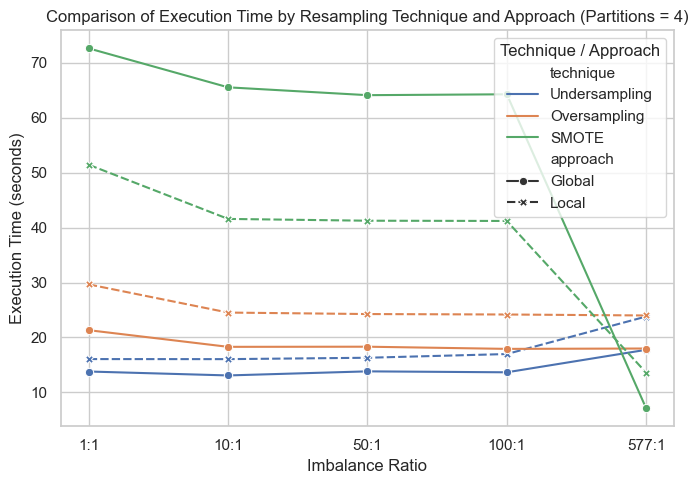

In [41]:
plt.figure(figsize=(7, 5))
plot = sns.lineplot(
    data=df_partition_4,
    x="ratio_label",
    y="time",
    hue="technique",
    style="approach",
    markers=True,
    dashes=True,
)
plot.set_title("Comparison of Execution Time by Resampling Technique and Approach (Partitions = 4)")
plot.set_ylabel("Execution Time (seconds)")
plot.set_xlabel("Imbalance Ratio")

plt.xticks(rotation=0)
plt.legend(title="Technique / Approach", loc='best')
plt.tight_layout()
plt.savefig("ExecutionTime.png") 
plt.show()

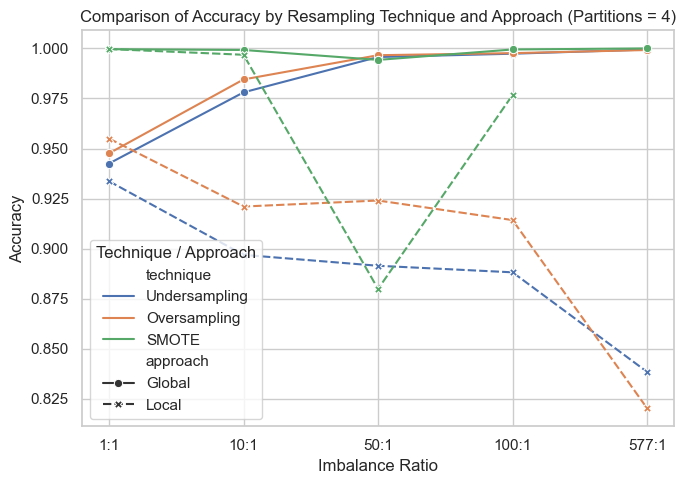

In [42]:
plt.figure(figsize=(7, 5))
plot = sns.lineplot(
    data=df_partition_4,
    x="ratio_label",
    y="accuracy",
    hue="technique",
    style="approach",
    markers=True,
    dashes=True,
)
plot.set_title("Comparison of Accuracy by Resampling Technique and Approach (Partitions = 4)")
plot.set_ylabel("Accuracy")
plot.set_xlabel("Imbalance Ratio")

plt.xticks(rotation=0)
plt.legend(title="Technique / Approach", loc='best')
plt.tight_layout()
plt.savefig("Accuracy.png") 
plt.show()


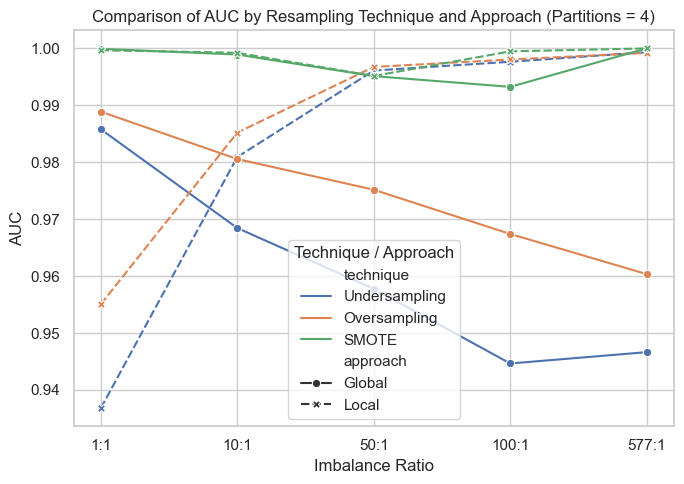

In [43]:
plt.figure(figsize=(7, 5))
plot = sns.lineplot(
    data=df_partition_4,
    x="ratio_label",
    y="auc",
    hue="technique",
    style="approach",
    markers=True,
    dashes=True,
)
plot.set_title("Comparison of AUC by Resampling Technique and Approach (Partitions = 4)")
plot.set_ylabel("AUC")
plot.set_xlabel("Imbalance Ratio")

plt.xticks(rotation=0)
plt.legend(title="Technique / Approach", loc='best')
plt.tight_layout()
plt.savefig("AUC.png") 
plt.show()

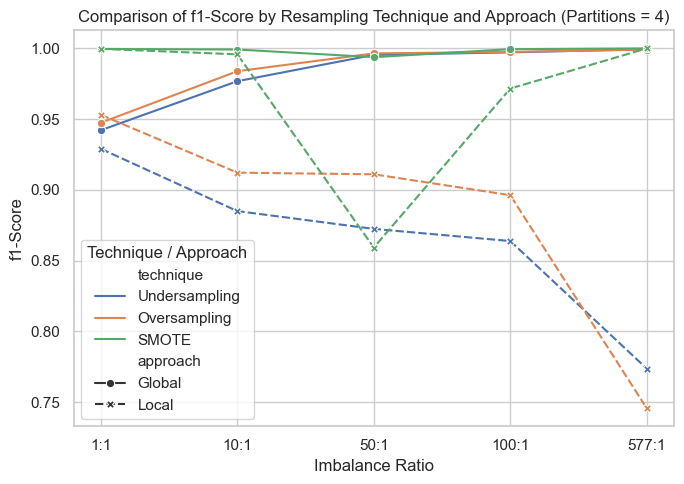

In [44]:
plt.figure(figsize=(7, 5))
plot = sns.lineplot(
    data=df_partition_4,
    x="ratio_label",
    y="f1",
    hue="technique",
    style="approach",
    markers=True,
    dashes=True,
)
plot.set_title("Comparison of f1-Score by Resampling Technique and Approach (Partitions = 4)")
plot.set_ylabel("f1-Score")
plot.set_xlabel("Imbalance Ratio")

plt.xticks(rotation=0)
plt.legend(title="Technique / Approach", loc='best')
plt.tight_layout()
plt.savefig("f1-Score.png") 
plt.show()


In [48]:
df = spark.read.json("resultsv1.eventlog")

In [49]:
df.printSchema()

root
 |-- App ID: string (nullable = true)
 |-- App Name: string (nullable = true)
 |-- Block Manager ID: struct (nullable = true)
 |    |-- Executor ID: string (nullable = true)
 |    |-- Host: string (nullable = true)
 |    |-- Port: long (nullable = true)
 |-- Classpath Entries: struct (nullable = true)
 |    |-- C:\Users\Mustafa\anaconda3\Lib\site-packages\pyspark\bin\..\conf: string (nullable = true)
 |    |-- C:\Users\Mustafa\anaconda3\Lib\site-packages\pyspark\jars\HikariCP-2.5.1.jar: string (nullable = true)
 |    |-- C:\Users\Mustafa\anaconda3\Lib\site-packages\pyspark\jars\JLargeArrays-1.5.jar: string (nullable = true)
 |    |-- C:\Users\Mustafa\anaconda3\Lib\site-packages\pyspark\jars\JTransforms-3.1.jar: string (nullable = true)
 |    |-- C:\Users\Mustafa\anaconda3\Lib\site-packages\pyspark\jars\RoaringBitmap-0.9.45.jar: string (nullable = true)
 |    |-- C:\Users\Mustafa\anaconda3\Lib\site-packages\pyspark\jars\ST4-4.0.4.jar: string (nullable = true)
 |    |-- C:\Users\Mus

In [54]:
from pyspark.sql.functions import col, sum as _sum

job_start = df.filter(df.Event == "SparkListenerJobStart") \
    .select("Job ID", "Submission Time", col("Properties").getItem("spark.job.description").alias("JobDescription"))

job_end = df.filter(df.Event == "SparkListenerJobEnd") \
    .select("Job ID", "Completion Time")

job_times = job_start.join(job_end, "Job ID") \
    .withColumn("ExecutionTime_sec", (col("Completion Time") - col("Submission Time")) / 1000)

execution_summary = job_times.groupBy("JobDescription") \
    .agg(_sum("ExecutionTime_sec").alias("TotalExecTime_sec")) \
    .orderBy("JobDescription")

execution_summary.show(n=1000, truncate=False)

+-------------------------------------------------+------------------+
|JobDescription                                   |TotalExecTime_sec |
+-------------------------------------------------+------------------+
|NULL                                             |13.413            |
|                                                 |54.72500000000001 |
|Global (Oversampling, ratio 100:1, partitions16) |15.799000000000003|
|Global (Oversampling, ratio 100:1, partitions2)  |20.18             |
|Global (Oversampling, ratio 100:1, partitions4)  |16.852            |
|Global (Oversampling, ratio 100:1, partitions8)  |15.415000000000001|
|Global (Oversampling, ratio 10:1, partitions16)  |16.198            |
|Global (Oversampling, ratio 10:1, partitions2)   |21.190999999999995|
|Global (Oversampling, ratio 10:1, partitions4)   |17.218            |
|Global (Oversampling, ratio 10:1, partitions8)   |15.392999999999999|
|Global (Oversampling, ratio 1:1, partitions16)   |18.084            |
|Globa

In [55]:
shuffle_metrics = df.filter(df.Event == "SparkListenerTaskEnd").select(
    col("Stage ID"),
    col("Task Metrics.Shuffle Read Metrics.Remote Bytes Read").alias("RemoteRead"),
    col("Task Metrics.Shuffle Read Metrics.Local Bytes Read").alias("LocalRead"),
    col("Task Metrics.Shuffle Write Metrics.Shuffle Bytes Written").alias("ShuffleWrite")
).withColumn(
    "TotalShuffleRead", col("RemoteRead") + col("LocalRead")
)

shuffle_per_stage = shuffle_metrics.groupBy("Stage ID").agg(
    _sum("TotalShuffleRead").alias("TotalShuffleRead_bytes"),
    _sum("ShuffleWrite").alias("TotalShuffleWrite_bytes")
)

In [57]:
from pyspark.sql.functions import explode
stage_to_job = df.filter(df.Event == "SparkListenerJobStart").select(
    col("Job ID"),
    explode(col("Stage IDs")).alias("Stage ID")
)


In [58]:
job_descriptions = df.filter(df.Event == "SparkListenerJobStart").select(
    col("Job ID"),
    col("Properties.`spark.job.description`").alias("JobDescription")
).dropna()

In [59]:
shuffle_summary = shuffle_per_stage.join(stage_to_job, on="Stage ID")
shuffle_summary = shuffle_summary.join(job_descriptions, on="Job ID")

shuffle_by_job = shuffle_summary.groupBy("JobDescription").agg(
    _sum("TotalShuffleRead_bytes").alias("TotalShuffleRead"),
    _sum("TotalShuffleWrite_bytes").alias("TotalShuffleWrite")
)
shuffle_by_job.show(n=shuffle_by_job.count(), truncate=False)



+-------------------------------------------------+----------------+-----------------+
|JobDescription                                   |TotalShuffleRead|TotalShuffleWrite|
+-------------------------------------------------+----------------+-----------------+
|Global (SMOTE, ratio 50:1, partitions16)         |507259096       |571592482        |
|Global (SMOTE, ratio 100:1, partitions8)         |497938911       |557857971        |
|Local (SMOTE, ratio 10:1, partitions2)           |224358183       |224358183        |
|Global (Undersampling, ratio 1:1, partitions16)  |6316699         |6485027          |
|Global (Undersampling, ratio 10:1, partitions16) |16787012        |17898506         |
|Local (SMOTE, ratio 100:1, partitions4)          |205759674       |205759674        |
|Local (Undersampling, ratio 10:1, partitions16)  |3977664         |3977664          |
|Global (Undersampling, ratio 50:1, partitions8)  |50092590        |55276781         |
|Global (Undersampling, ratio 577:1, partit